# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Vehicle Detection and Tracking

### Starter code

#### Import of libraries

In [2]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

#### Declaration of global variables

In [96]:
car_complete_data_path = "complete-dataset/vehicles/*.png"
noncar_complete_data_path = "complete-dataset/non-vehicles/*.png"
car_partial_data_path = "partial-dataset/vehicles/*.jpeg"
noncar_partial_data_path = "partial-dataset/non-vehicles/*.jpeg"
test_images_path = "test_images/*.jpg"
output_images_path = "output_images/"

#### Extract images using glob

In [4]:
def extract_images(imgs_path, return_path_only=True):
    images = []
    images_path = glob.glob(imgs_path)
    if (return_path_only == False):
        for image_path in images_path:
            image = cv2.imread(image_path)
            images.append(image)
    images = np.array(images)
    return_dict = {
        "imgs_path": images_path,
        "imgs": images
    }
    return return_dict
# extract = extract_images(car_partial_data_path, return_path_only=False)
# print(len(extract["imgs_path"]))
# print(len(extract["imgs"]))
# plt.imshow(extract[imgs][0])
# plt.show()

#### Dataset exploration

In [6]:
def explore_data(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_img = cv2.imread(car_list[0])
    shape = test_img.shape
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
cars = extract_images(car_complete_data_path)["imgs_path"]
noncars = extract_images(noncar_complete_data_path)["imgs_path"]
exploration = explore_data(cars, noncars)
print("Number of car images: ", exploration["n_cars"])
print("Number of noncar images: ", exploration["n_notcars"])
print("Shape of training images: ", exploration["image_shape"])
print("Data type of training images: ", exploration["data_type"])

Number of car images:  8792
Number of noncar images:  8968
Shape of training images:  (64, 64, 3)
Data type of training images:  uint8


###  Goal 1 - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

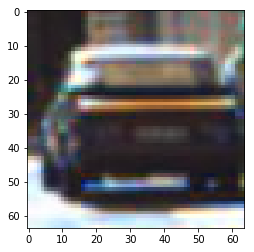

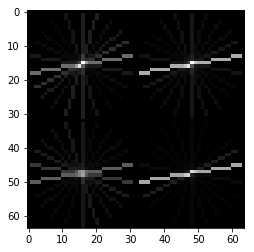

In [68]:
def hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, do_transform_sqrt=True, visualization=False, feature_vec=True):
    if visualization == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=visualization, feature_vector=feature_vec)
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=do_transform_sqrt, visualise=visualization, feature_vector=feature_vec)
        hog_image = None
    return features, hog_image
image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hog_feat, hog_image = hog_features(gray, orient=11, pix_per_cell=32, cell_per_block=2, visualization=True)
plt.imshow(image)
plt.show()
plt.imshow(hog_image, cmap="gray")
plt.show()

#### Extract HOG features from a set of images and create feature vector for each image

In [69]:
def extract_hog_features(imgs, is_image_path=True, color_space="HSV", orient=9, pix_per_cell=8, cell_per_block=2, hog_channel="ALL", do_transform_sqrt=True, visualization=False, feature_vec=True):
    features = []
    original_color_space = "BGR"
    for img in imgs:
        if (is_image_path == True):
            img = cv2.imread(img)
        if (color_space != original_color_space):
            img = cv2.cvtColor(img, eval("cv2.COLOR_BGR2" + color_space))
        if (hog_channel == "ALL"):
            img_features = []
            for channel in range(img.shape[2]): 
                img_features.extend(hog_features(img[:,:,channel], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, do_transform_sqrt=do_transform_sqrt, visualization=visualization)[0])
        else:
            img_features = hog_features(img[:,:, hog_channel], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, visualization=visualization)[0]
        features.append(img_features)
    return np.array(features)
# images = cv2.imread(extract_images(car_partial_data_path)["imgs_path"][0])
# features = extract_hog_features([images], is_image_path=False, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
# print(len(features))
# print(features[0])

### Goal 2 - Apply a color transform and extract binned color features, as well as histograms of color.

#### Spatial binning of images

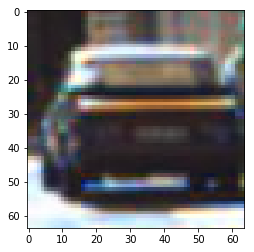

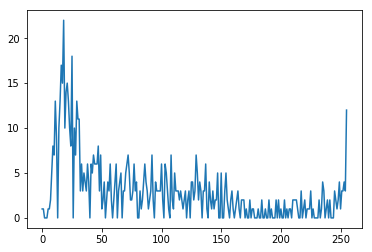

In [28]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
bin_features = bin_spatial(image, size=(16, 16))
plt.imshow(image)
plt.show()
plt.plot(np.histogram(bin_features, bins=256)[0])
plt.show()

#### Histogram of color

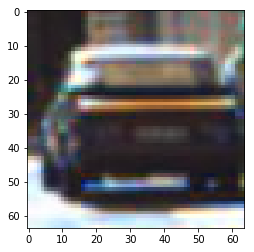

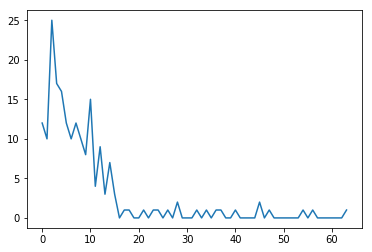

In [26]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
hist_features = color_hist(image, nbins=64, bins_range=(0, 256))
plt.imshow(image)
plt.show()
plt.plot(np.histogram(hist_features, bins=64)[0])
plt.show()

#### Extract color features obtained from spatial binning and histogram of color and merge them into single feature vector for an image

In [30]:
def extract_color_features(imgs, is_image_path=True, spatial_feat=True, hist_feat=True, colorspace=['BGR'], 
                           spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    original_color_space = 'BGR'
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    for img in imgs:
        if (is_image_path):
            img = cv2.imread(img)
        if (spatial_feat):
            bin_features_cspace = []
            for cspace in colorspace:
                if (cspace != original_color_space):
                    img = cv2.cvtColor(img, eval("cv2.COLOR_BGR2" + cspace))
                bin_features_cspace.append(bin_spatial(img, spatial_size))
            bin_features = [y for x in bin_features_cspace for y in x]
        if (hist_feat):
            color_hist_features_cspace = []
            color_hist_features_cspace.append(color_hist(img, hist_bins, hist_range))
            color_hist_features = [y for x in color_hist_features_cspace for y in x]
        features.append(np.concatenate((bin_features, color_hist_features)))
    # Return list of feature vectors
    return np.array(features)
# image = extract_images(car_partial_data_path)["imgs_path"][0:2]
# features = extract_color_features(image, spatial_feat=True, hist_feat=True, colorspace=['BGR', 'HSV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
# print(len(features))

### Goal 3 - Normalization of features and randomize a selection for training and testing.

#### Normalization of features

In [31]:
def normalize_features(features, return_raw_features=False):
    # Create an array stack of feature vectors
    X = np.vstack(features).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    if (return_raw_features):
        return_val = (scaled_X, X_scaler, X)
    else:
        return_val = (scaled_X, X_scaler)
    return return_val
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# combined_features = (car_features, noncar_features)
# normalized_features, scaler, X = normalize_features(combined_features, return_raw_features=True)
# fig = plt.figure(figsize=(12,4))
# plt.subplot(131)
# plt.imshow(cv2.imread(car_images[100]))
# plt.title('Original Image')
# plt.subplot(132)
# plt.plot(X[100])
# plt.title('Raw Features')
# plt.subplot(133)
# plt.plot(normalized_features[100])
# plt.title('Normalized Features')
# fig.tight_layout()
# plt.show()
# print("Number of cars/carsfeatures are:", len(car_features), "Number of noncars/noncars features are:", len(noncar_features), "Number of normalized vectors are:", len(normalized_features))

#### Create training, validation and testing dataset by splitting the whole dataset

In [33]:
def split_dataset(dataset, test_split_ratio=0.2):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(dataset["scaled_X"], dataset["y"], 
                                                        test_size=test_split_ratio, random_state=rand_state)
    return (X_train, y_train, X_test, y_test)
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR', 'YUV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR', 'YUV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
# scaled_X, scaler = normalize_features((car_features, noncar_features))
# labels_car = [1 for i in range(len(car_images))]
# labels_noncar = [0 for i in range(len(noncar_images))]
# labels = np.concatenate((labels_car, labels_noncar))
# dataset = {
#     "scaled_X": scaled_X,
#     "y": labels
# }
# X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
# print(len(X_train), len(y_train), len(X_test), len(y_test))

### Goal 4 - Train a classifier Linear SVM classifier on extracted features

#### Train a linear SVM classifier and measure the accuracy on test set

In [35]:
def train_SVC(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return svc
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# scaled_X, scaler = normalize_features((car_features, noncar_features))
# labels_car = [1 for i in range(len(car_images))]
# labels_noncar = [0 for i in range(len(noncar_images))]
# labels = np.concatenate((labels_car, labels_noncar))
# dataset = {
#     "scaled_X": scaled_X,
#     "y": labels
# }
# X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
# clf = train_SVC(X_train, y_train, X_test, y_test)
#accuracy = clf.score(X_test, y_test)
# print(accuracy)

#### Train SVC classifier on extracted color features only

In [36]:
def train_on_color_features(car_imgs_path, noncar_imgs_path):
    
    car_features = extract_color_features(car_imgs_path, spatial_feat=True, hist_feat=True, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    noncar_features = extract_color_features(noncar_imgs_path, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    scaled_X, scaler = normalize_features((car_features, noncar_features))
    labels_car = [1 for i in range(len(car_features))]
    labels_noncar = [0 for i in range(len(noncar_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf = train_SVC(X_train, y_train, X_test, y_test)
    color_accuracy = clf.score(X_test, y_test)
    return (clf, scaler, color_accuracy)
car_images = extract_images(car_complete_data_path)["imgs_path"]
noncar_images = extract_images(noncar_complete_data_path)["imgs_path"]
clf, scaler, color_accuracy = train_on_color_features(car_images, noncar_images)
print("Test set accuracy obtained by training on color features only is: ", color_accuracy)

13.66 Seconds to train SVC...
Test set accuracy obtained by training on color features only is:  0.959177927928


#### Train SVC on extracted HOG features only

In [70]:
def train_on_hog_features(car_imgs_path, noncar_imgs_path):
    
    car_hog_features = extract_hog_features(car_imgs_path, hog_channel="ALL", color_space="YCrCb" ,orient=11, pix_per_cell=32, cell_per_block=2)
    
    noncar_hog_features = extract_hog_features(noncar_imgs_path, hog_channel="ALL", color_space="YCrCb", orient=11, pix_per_cell=32, cell_per_block=2)
    
    scaled_X, scaler = normalize_features((car_hog_features, noncar_hog_features))
    labels_car = [1 for i in range(len(car_hog_features))]
    labels_noncar = [0 for i in range(len(noncar_hog_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf =  train_SVC(X_train, y_train, X_test, y_test)
    hog_accuracy = clf.score(X_test, y_test)
    return (clf, scaler, hog_accuracy)
car_images = extract_images(car_complete_data_path)["imgs_path"]
noncar_images = extract_images(noncar_complete_data_path)["imgs_path"]
clf, scaler, hog_accuracy = train_on_hog_features(car_images, noncar_images)
print("Test set accuracy obtained by training on HOG features only is:", hog_accuracy)

2.05 Seconds to train SVC...
Test set accuracy obtained by training on HOG features only is: 0.977477477477


#### Train SVC on all features extracted (In this case, color and HOG features)

In [71]:
def train_on_all_features(car_imgs_path, noncar_imgs_path):
    car_hog_features = extract_hog_features(car_imgs_path, color_space="YCrCb", orient=11, pix_per_cell=32, cell_per_block=2)
    car_color_features = extract_color_features(car_imgs_path, spatial_feat=True, hist_feat=True, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    noncar_hog_features = extract_hog_features(noncar_imgs_path, color_space="YCrCb", orient=11, pix_per_cell=32, cell_per_block=2)
    noncar_color_features = extract_color_features(noncar_imgs_path, spatial_feat=True, hist_feat=True, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    car_all_features = np.concatenate((car_color_features, car_hog_features), axis=1)
    noncar_all_features = np.concatenate((noncar_color_features, noncar_hog_features), axis=1)
    
    scaled_X, scaler = normalize_features((car_all_features, noncar_all_features))
    labels_car = [1 for i in range(len(car_hog_features))]
    labels_noncar = [0 for i in range(len(noncar_hog_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf = train_SVC(X_train, y_train, X_test, y_test)
    accuracy = clf.score(X_test, y_test)
    return (clf, scaler, accuracy)
car_images = extract_images(car_complete_data_path)["imgs_path"]
noncar_images = extract_images(noncar_complete_data_path)["imgs_path"]
clf, scaler, accuracy = train_on_all_features(car_images, noncar_images)
print("Test set accuracy obtained by training on all features (Color and HOG) is:", accuracy)

4.34 Seconds to train SVC...
Test set accuracy obtained by training on all features (Color and HOG) is: 0.986768018018


### Goal 5 - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

#### Utility method to draw bounding boxes around diagonal of pixels in an image

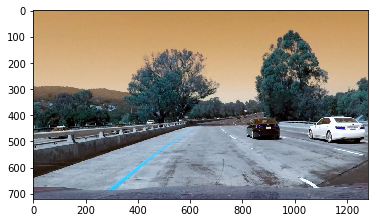

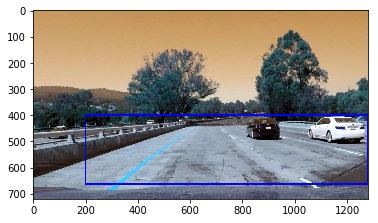

In [101]:
def draw_bounding_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        draw_img = cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img
image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
box_image = draw_bounding_boxes(image, [((200, 400), (1280, 662))])
plt.imshow(image)
plt.show()
plt.imshow(box_image)
plt.show()

#### Sliding window technique implementation

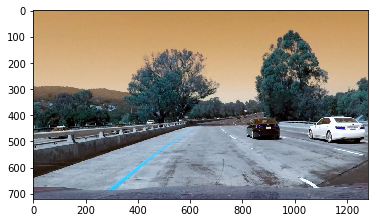

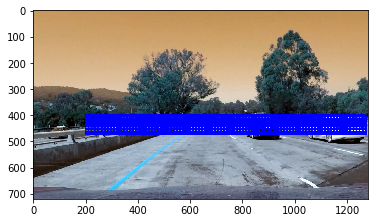

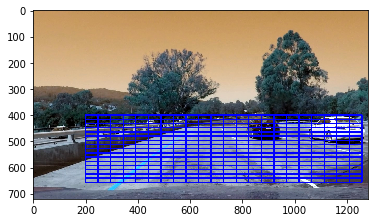

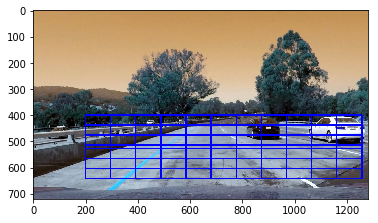

In [78]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    window_xy_size=(64, 64), window_xy_overlap=(0.5, 0.5)):
    img_shape = img.shape
    window_list = []
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(window_xy_size[0]*(1 - window_xy_overlap[0]))
    ny_pix_per_step = np.int(window_xy_size[1]*(1 - window_xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(window_xy_size[0]*(window_xy_overlap[0]))
    ny_buffer = np.int(window_xy_size[1]*(window_xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    for y_window in range(ny_windows):
        for x_window in range(nx_windows):
            # Calculate window position
            startx = x_window*nx_pix_per_step + x_start_stop[0]
            endx = startx + window_xy_size[0]
            starty = y_window*ny_pix_per_step + y_start_stop[0]
            endy = starty + window_xy_size[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
plt.imshow(image)
plt.show()
total_window_boxes = slide_window(image, x_start_stop=(int(0.15625*image.shape[1]), image.shape[1]), 
                                       y_start_stop=(int(0.5556*image.shape[0]), 0.6597*image.shape[0]), 
                                       window_xy_size=(64, 32), window_xy_overlap=(0.8, 0.8))
box_image = draw_bounding_boxes(image, total_window_boxes)
plt.imshow(box_image)
plt.show()
total_window_boxes = slide_window(image, x_start_stop=(int(0.15625*image.shape[1]), image.shape[1]), 
                                       y_start_stop=(int(0.5556*image.shape[0]), int(0.9208*image.shape[0])), 
                                       window_xy_size=(96, 64), window_xy_overlap=(0.5, 0.75))
box_image = draw_bounding_boxes(image, total_window_boxes)
plt.imshow(box_image)
plt.show()
total_window_boxes = slide_window(image, x_start_stop=(int(0.15625*image.shape[1]), image.shape[1]), 
                                           y_start_stop=(int(0.5556*image.shape[0]), 0.9208*image.shape[0]), 
                                           window_xy_size=(192, 128), window_xy_overlap=(0.5, 0.7))
box_image = draw_bounding_boxes(image, total_window_boxes)
plt.imshow(box_image)
plt.show()

### Run the trained classifier on boxes returned by sliding window and predict if the box contains a car or noncar

#### Extract features for an image (here, part of an image bounded by sliding window)

In [79]:
def extract_single_img_features(img, spatial_feat, spatial_feat_config, color_hist_feat, color_hist_feat_config,
                                hog_feat, hog_feat_config):
    features = []
    if (spatial_feat == True or color_hist_feat == True):
        color_features = extract_color_features([img], is_image_path=False, 
                                        spatial_feat=spatial_feat, colorspace=spatial_feat_config["colorspace"],
                                       spatial_size=spatial_feat_config["spatial_size"], hist_feat=color_hist_feat,
                                       hist_bins=color_hist_feat_config["hist_bins"], 
                                        hist_range=color_hist_feat_config["hist_range"])
        features.append(color_features)

    if (hog_feat == True): 
        hog_features = extract_hog_features([img], is_image_path=False, color_space=hog_feat_config["color_space"],
                                            orient=hog_feat_config["orient"],
                                           pix_per_cell=hog_feat_config["pix_per_cell"],
                                           cell_per_block=hog_feat_config["cell_per_block"],
                                           hog_channel=hog_feat_config["hog_channel"], 
                                            do_transform_sqrt=hog_feat_config["do_transform_sqrt"])
        features.append(hog_features)
    return np.concatenate(features, axis=1)

#### Run the trained classifier and predict car/noncar class

In [80]:
def predict_class(img, clf, scaler, spatial_feat_config, color_hist_feat_config, hog_feat_config, 
                  spatial_feat=True, color_hist_feat=True, hog_feat=True):
    img_features = extract_single_img_features(img, spatial_feat=spatial_feat, spatial_feat_config=spatial_feat_config, 
                                        color_hist_feat=color_hist_feat, color_hist_feat_config=color_hist_feat_config,
                                        hog_feat=hog_feat, hog_feat_config=hog_feat_config)
    #Scale and normalize the features
    img_features = scaler.transform(np.array(img_features).reshape(1, -1))
    #Predict class
    pred = clf.predict(img_features)
    return pred

#### Extract image section from bounding boxes of windows detected by sliding window algorithm

In [81]:
def extract_imgs_from_windows(original_img, windows):
    imgs = []
    for window in windows:
        imgs.append(cv2.resize(original_img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)))
    return imgs
# image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
# window_bboxes = slide_window(image, y_start_stop=(int(0.5556*image.shape[0]), 0.9208*image.shape[0]), 
#                                      window_xy_size=(128, 128))
# window_imgs = extract_imgs_from_windows(image, window_bboxes)
# plt.imshow(image)
# plt.show()
# for img in window_imgs:
#     plt.imshow(img)
#     plt.show()

#### Pipeline code undergoing following steps:

    1. Definition of config for color features as follows:
        a. Color space - BGR and YUV
        b. Bin size used in spatial binning - 16 x 16
        c. Total number of histogram bins - 64
        d. Pixel range over which histogram is calculated - (0, 256)
        
    2. Definition of config for HOG features as follows:
        a. Number of orientations - 11
        b. Pixels per cell - 32
        c. Cells per HOG computation block - 2
        d. HOG features are calculated for all channels
        e. Color Space - YCrCb
        f. Sqaure root transform is applied to reduce the effects of shadows and lightness changes

    3. Sliding window search for cars is implemented as follows:
        a. In X axis (horizontal axis), search is limited to 85% of image pixels from right, i.e. 15% section from left is
            cropped. This was done as no cars in moving in the direction of car can be expected on the left as the car is 
            moving in the left most lane. Also, search limitation speeds up the pipeline.
        b. In Y axis (vertical axis), search is limited to 37% of image pixels in between, i.e. 55% section from top and 8%
            section from bottom is cropped. This was done to as no cars can be seen in top portion of the image. Also, search
            limitation speeds up the pipeline.
        c. Car detection are tricky as the shape of car varies in size for a nearer and farther away car. To achieve 
            efficient detection, sliding windows of multiple shapes (scales) were used. Details are as follows:
            
            Window dimensions for 55% to 92% in Y axis from top (Span the entire region of interest) - 96 x 64 with overlap 
                of 50% and 75% in x and y axis respectively.
            Window dimensions for 55% to 66% in Y axis from top (Span few cells in top region of interest) - 64 x 32 with
                overlap of 80% both in x and y axis.
            Window dimensions for 55% to 92% in Y axis from top (Span the entire region of interest) - 192 x 128 with overlap
                of 50% and 70% in x and y axis respectively.

    4. SVM classifier is run over each image portion derived from sliding windows. Before running the classifier, the image 
        portion is resized to 64 x 64 as the classifier was trained on 64 x 64 images.

    5. A heat map of all positive detections (A car is found) is created. In case of overlapping detections, the region of 
        overlap gets more heated.
 
    6. Heat map thresholding is done to retain detections where a minimum overlap is 4 (All detections below 3 overlaps are
        removed)
        
    7. After heat map thresholding, bounding boxes for retained heat regions are labelled. These act as labels for detected 
        cars.
        
    8. All labelled detections containing less than 0.05% pixels in X and Y axes are rejected as car cannot be so small in 
        size.
    
    8. Vehicle tracker is used for achieving smooth detections and rejection of false positives when pipeline is run over 
        video

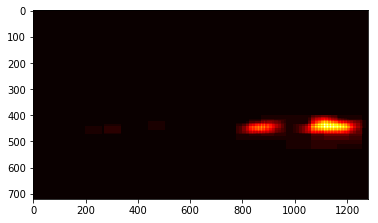

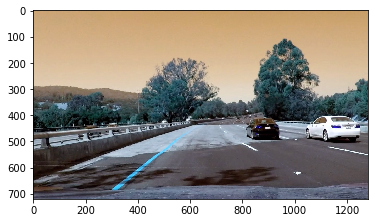

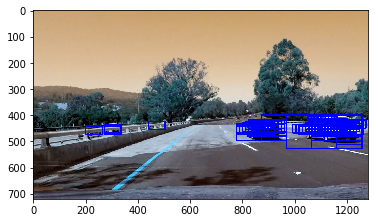

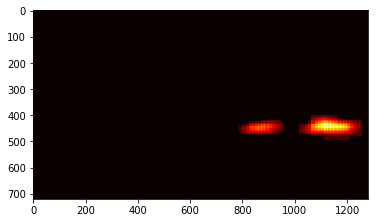

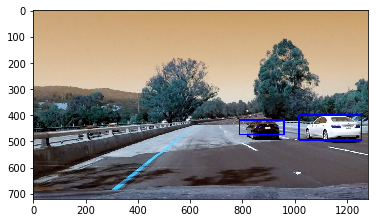

In [108]:
def draw_predicted_cars(original_img, clf, scaler, vehicle_tracker, use_vehicle_tracker=False):
    #Declare and define feature extraction configuration paramters
    spatial_feat_config = {
        "colorspace": ["BGR", "YUV"],
        "spatial_size": (16, 16)
    }
    color_hist_feat_config = {
        "hist_bins": 64,
        "hist_range": (0, 256)
    }
    hog_feat_config = {
        "orient": 11,
        "pix_per_cell": 32,
        "cell_per_block": 2,
        "hog_channel": "ALL",
        "color_space": "YCrCb",
        "do_transform_sqrt": True
    }
    heat_threshold = 3
    minimum_box_detection_dim = (int(0.055*original_img.shape[1]), int(0.055*original_img.shape[0]))
    car_windows = []
    total_window_boxes = []
    total_window_boxes.extend(slide_window(original_img, x_start_stop=(int(0.15625*original_img.shape[1]), original_img.shape[1]), 
                                           y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
                                           window_xy_size=(96, 64), window_xy_overlap=(0.5, 0.75)))
    total_window_boxes.extend(slide_window(original_img, x_start_stop=(int(0.15625*original_img.shape[1]), original_img.shape[1]), 
                                           y_start_stop=(int(0.5556*original_img.shape[0]), 0.6597*original_img.shape[0]), 
                                           window_xy_size=(64, 32), window_xy_overlap=(0.8, 0.8)))
    total_window_boxes.extend(slide_window(original_img, x_start_stop=(int(0.15625*original_img.shape[1]), original_img.shape[1]), 
                                           y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
                                           window_xy_size=(192, 128), window_xy_overlap=(0.5, 0.7)))

    window_imgs = extract_imgs_from_windows(original_img, total_window_boxes)
    
    for i in range(len(window_imgs)):
        window_img = window_imgs[i]
        pred = predict_class(window_img, clf, scaler, spatial_feat=True, spatial_feat_config=spatial_feat_config, 
                      color_hist_feat=True, color_hist_feat_config=color_hist_feat_config,
                      hog_feat=True, hog_feat_config=hog_feat_config)
        
        if (pred == 1):
            car_windows.append(total_window_boxes[i])

    
    car_predicted_image = draw_bounding_boxes(original_img, car_windows, color=(0, 0, 255))

    heat_map = create_heat_map(original_img, car_windows)
    
    plt.imshow(heat_map, cmap="hot")
    plt.show()
    
    thresh_heat_map = apply_threshold_to_heat_map(heat_map, heat_threshold)
    
    if (use_vehicle_tracker):
        heat_map_without_false_positives = vehicle_tracker.get_smooth_detections(thresh_heat_map)        
        labeled_img = label(heat_map_without_false_positives)
        car_boxes = extract_bbox_in_heat_map(labeled_img)

    else:
        labeled_img = label(thresh_heat_map)
        car_boxes = extract_bbox_in_heat_map(labeled_img)
    filtered_small_box_img = filter_out_small_detections(car_boxes, minimum_box_dim=minimum_box_detection_dim)
    car_filtered_img = draw_bounding_boxes(original_img, filtered_small_box_img)
    return (car_predicted_image, thresh_heat_map, car_filtered_img)
image_path = extract_images(test_images_path)["imgs_path"][3]
test_image = cv2.imread(image_path)
car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
plt.imshow(test_image)
plt.show()
plt.imshow(car_detected_image)
plt.show()
plt.imshow(heat_map, cmap="hot")
plt.show()
plt.imshow(car_filtered_img, cmap="hot")
plt.show()
# # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

### Goal 6 - Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

#### Apply vehicle detection algorithm on video stream

In [83]:
def laneDetectionInVideo (sourceFilePath, outputFilePath):
    vehicle_tracker = VehicleTracker()
    originalVideoClip = VideoFileClip(sourceFilePath)
    car_detected = originalVideoClip.fl_image(vehicle_tracker.process_image_frames)
    %time car_detected.write_videofile(outputFilePath, audio=False)

#### Create a heat map around predicted car detections

In [84]:
def create_heat_map(img, bboxes):
    heat_img = np.zeros_like(img[:,:,0])
    for box in bboxes:
        heat_img[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heat_img

#### Apply a thresholded heat map

In [85]:
def apply_threshold_to_heat_map(heat_map, threshold=1):
    thresh_heat_map = np.copy(heat_map)
    thresh_heat_map[heat_map <= threshold] = 0
    return thresh_heat_map

#### Filter out bounding boxes containing less than minimum pixels in X and Y axes. Retain only others

In [86]:
def filter_out_small_detections(bboxes, minimum_box_dim=(50, 50)):
    filtered_bboxes = []
    for box in bboxes:
        box_x_len = box[1][0] - box[0][0]
        box_y_len = box[1][1] - box[0][1]
        if ((box_x_len > minimum_box_dim[0]) and (box_y_len > minimum_box_dim[1])):
            filtered_bboxes.append(box)
    return filtered_bboxes

#### Extract bounding boxes around labelled heat map

In [87]:
def extract_bbox_in_heat_map(labeled_heat_img):
    bboxes = []
    for car in range(1, labeled_heat_img[1]+1):
        nonzero = (labeled_heat_img[0] == car).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

### Goal 7 - Estimate a bounding box for vehicles detected.

#### Create Vehicle tracker class to track positions of vehicles detected subsequent frames

In [88]:
class VehicleTracker():
    def __init__(self):
        self.last_heatmap = None
        self.frames_counter = 1
    
    def get_smooth_detections(self, current_heat_map):
        if (self.last_heatmap == None):
            current_heat_map = apply_threshold_to_heat_map(current_heat_map, 4)
            self.last_heatmap = current_heat_map
            avg_heat_map = self.last_heatmap
        else:
            avg_heat_map = self.last_heatmap*0.7 + current_heat_map*0.4
            avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, 2)
        
        #Drop the retained average map after every 20 frames
        if (self.frames_counter % 20 == 0):
            self.last_heatmap = None

        self.frames_counter += 1
        return avg_heat_map
    
    def process_image_frames(self, image):
        #Convert image frame to BGR as pipline and classifier expects BGR images
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        predicted, heat_map, filtered = draw_predicted_cars(image, clf, scaler, self, use_vehicle_tracker=True)
        #Convert image frame back to RGB before writing to video
        filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)
        return filtered

### Train classifier

In [90]:
def train_classifier():
    car_images = extract_images(car_complete_data_path)["imgs_path"]
    noncar_images = extract_images(noncar_complete_data_path)["imgs_path"]
    clf, scaler, accuracy = train_on_all_features(car_images, noncar_images)
    print("Color and HOG features extracted and used for training. Test set accuracy obtained is:", accuracy)
train_classifier()

4.29 Seconds to train SVC...
Color and HOG features extracted and used for training. Test set accuracy obtained is: 0.989583333333


### Main method

In [94]:
def main(video_src, video_dst, run_on_video=False):
    if (run_on_video):
        laneDetectionInVideo(video_src, video_dst)
    else:
        test_images_paths = extract_images(test_images_path)["imgs_path"]
        for image_path in test_images_paths:
            test_image = cv2.imread(image_path)
            car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
            plt.imshow(test_image)
            plt.show()
            plt.imshow(car_filtered_img, cmap="hot")
            plt.show()
            cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
            "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

#### Run pipeline on test images

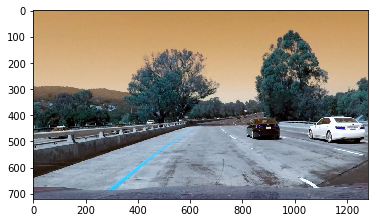

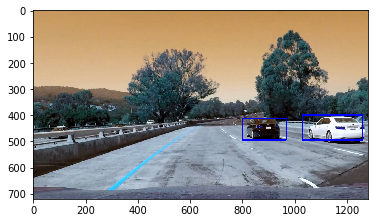

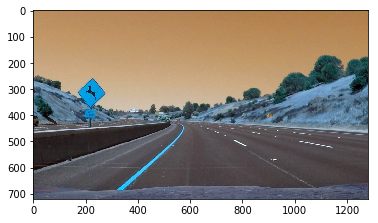

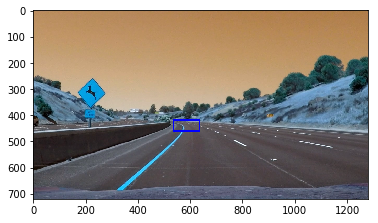

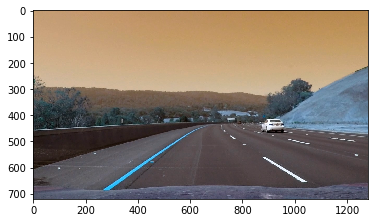

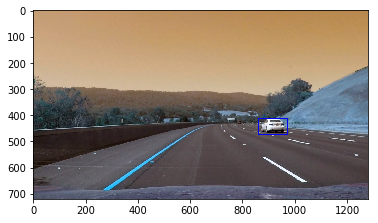

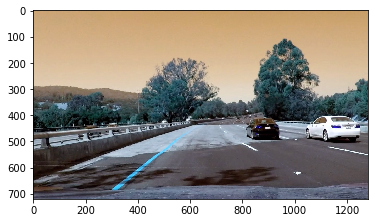

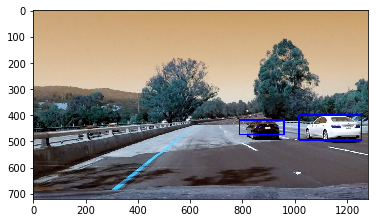

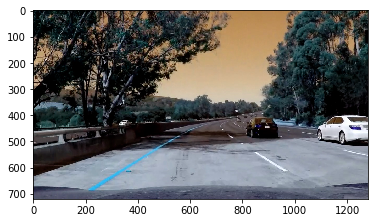

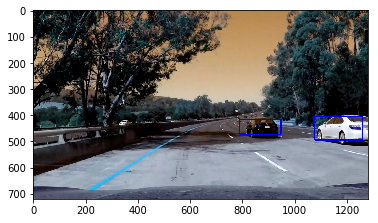

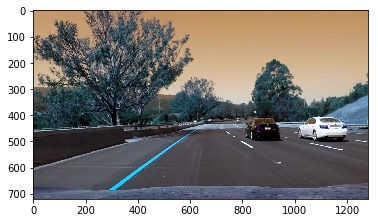

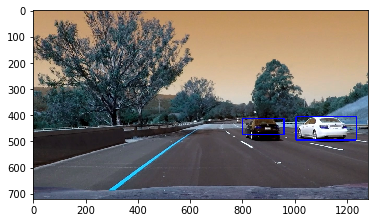

In [97]:
main(None, None)

#### Run pipepline on test and project video

In [99]:
main("test_video/test_video.mp4", "test_video_output.mp4", run_on_video=True)
main("test_video/project_video.mp4", "project_video_output.mp4", run_on_video=True)